In [ ]:
%pip install --upgrade numpy matplotlib scipy pingouin seaborn pyarrow xarray netcdf4 pyocclient

In [ ]:
%matplotlib inline

In [75]:
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# T-Tests with Pingouin

[**Pingouin**](https://pingouin-stats.org/index.html) is a statistics package in Python that wraps pandas and [scipy-stats](https://docs.scipy.org/doc/scipy/reference/stats.html), creating more-complete statistics reports and presenting the results in a readable way.


### T-Tests

T-tests compare the means of two samples of data generated from a normally-distributed population and compute the probability that they have the same mean.


| Code, | Statistical Test | Description |
| :-- | :-- | :-- |
| `pg.ttest(x, 0)` | One-Sampled T-Test | "Is the mean of my data unlikely to be zero?" |
| `pg.ttest(x, y)` | Independent-Samples T-Test | "Do the means of x and y indicate they are unlikely to be from the same distribution?" |
| `pg.ttest(x, y, paired=True)` | Paired-Samples T-test | "Comparing each value directly to its neighbor, are the mean differences of x and y's data unlikely to be zero?" |


**Exercises** let's do some analysis on some fake data to get a feel for these two statistics tools.

Generate the Data: Run the code below to create the dataset `df`.

<Axes: >

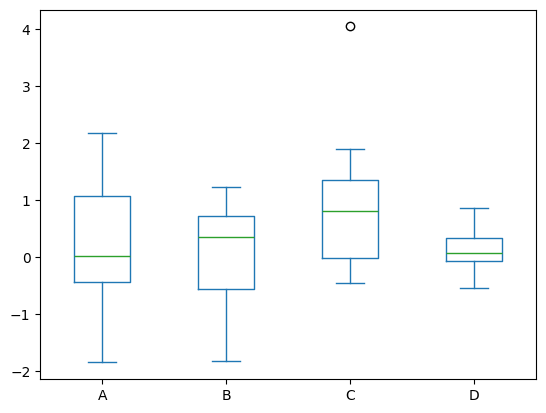

In [76]:
randomizer = np.random.RandomState(17)  # Makes sure the pseudorandom number generators reproduce the same data for us all.
df = pd.DataFrame()
df['A'] = randomizer.normal(0, 1, size=20)
df['B'] = randomizer.normal(0.2, 1, size=20)
df['C'] = randomizer.normal(0.7, 1, size=20)
df['D'] = df.A * 0.3 + randomizer.normal(0, 0.3, size=20)
df.plot.box()

### Analyze the Data with T-Tests in Pingouin

**A vs 0, One-Sampled T-Test (Example)**: Is the mean of the normally-distributed population that the the dataset A is generated from unlikely to be zero?

In [77]:
pg.ttest(df['A'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.378652,19,two-sided,0.709144,"[-0.45, 0.65]",0.084669,0.248,0.064966


**B vs 1, One-Sampled T-Test**: Is the mean of the normally-distributed population that the the dataset B is generated from unlikely to be one?

In [78]:
pg.ttest(df['B'], 1)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.449603,19,two-sided,0.000275,"[-0.26, 0.55]",0.994961,113.454,0.98794


**A vs B, Independent Samples T-Test**: Is the mean of the normally-distributed population that the the dataset `A` is generated from unlikely to be the same as the mean of the normally-distributed population that the the dataset `B` is generated from?

In [6]:
pg.ttest(df['A'], df['B'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.137189,38,two-sided,0.891606,"[-0.7, 0.61]",0.043383,0.311,0.052052


**A vs C, Independent Samples T-Test**: Is the mean of the normally-distributed population that the the dataset `A` is generated from unlikely to be the same as the mean of the normally-distributed population that the the dataset `C` is generated from?

In [7]:
pg.ttest(df['A'], df['C'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.978874,38,two-sided,0.055111,"[-1.42, 0.02]",0.625775,1.409,0.487608


**A vs C, Paired Samples T-Test**: Is the mean of the differences between each pair of samples in generated from the two normally-distributed populations `A` and `C`  unlikely to be 0?

In [8]:
pg.ttest(df['A'], df['C'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.728432,19,two-sided,0.100128,"[-1.55, 0.15]",0.625775,0.818,0.756449


**A vs D, Paired Samples T-Test**: Is the mean of the differences between each pair of samples in generated from the two normally-distributed populations `A` and `D`  unlikely to be 0?

In [9]:
pg.ttest(df['A'], df['D'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.082615,19,two-sided,0.935022,"[-0.45, 0.49]",0.02152,0.233,0.050959


## T-Tests on Real-World Data: Pupil Position Analysis

In the experiments reported by [Steinmetz et al, 2019 in Nature](https://www.nature.com/articles/s41586-019-1787-x), mice performed a discrimination task where they moved the position of a stimulus using a steering wheel. During the experiment, a camera recorded the pupil position of the subject in the x and y directions.


### Download the dataset and load it into a Pandas DataFrame

In [13]:
import owncloud

In [22]:
client = owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/7TrGeBWtQFGIGlY')
client.get_file('data/processed/steinmetz_2017-01-08_Muller.nc')

### Load and Filter the Data

Run the code below, which loads the file, extracts the variables, filters the data, and transforms it into a dataframe.

In [28]:
import xarray as xr

dset = xr.load_dataset('steinmetz_2017-01-08_Muller.nc')
dd = dset[['pupil_x', 'pupil_y', 'contrast_left', 'contrast_right', 'response_type']]
dd = dd.where(
    (dset.active_trials==True) 
    & (dset.response_type != 0)
    & (dset.time >= 0.5)
    & (dset.time <= 1.3)
    , drop=True)
dd['contrast_diff'] = dd['contrast_right'] - dd['contrast_left']
trials = dd.median(dim='time')
rdf = trials.to_dataframe()
rdf.head()

,pupil_x,pupil_y,contrast_left,contrast_right,response_type,contrast_diff
trial,,,,,,
1,-1.019465,0.754972,50.0,0.0,1.0,-50.0
2,-0.184417,0.509199,0.0,50.0,-1.0,50.0
3,0.799240,-0.486496,100.0,25.0,1.0,-75.0
4,-0.294746,-0.218956,0.0,100.0,-1.0,100.0
5,-0.367058,-0.259306,50.0,50.0,1.0,0.0


**Exercises**

Extract data from the dataframe `df1`, plot its distribution(s), and use a t-test to answer the questions below:

**Example**: For the trials where `contrast_left` was greater or equal to 50 and `contrast_right` was 0, was the average `pupil_x` position for the trial zero?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.447425,24,two-sided,0.002098,"[0.22, 0.88]",0.689485,18.185,0.910939


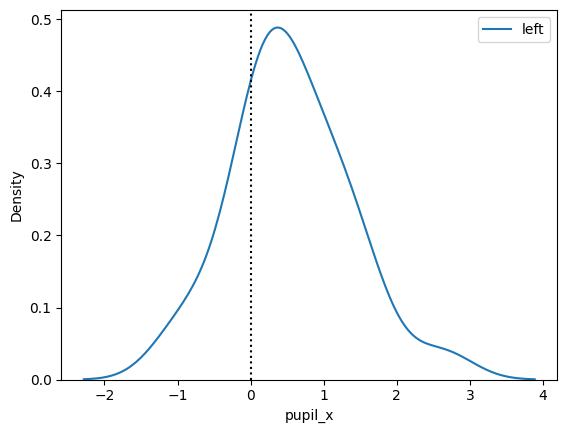

In [30]:
left = rdf[(rdf.contrast_left >= 50) & (rdf.contrast_right == 0)]
sns.kdeplot(left.pupil_x, label='left')
plt.axvline(0, color='black', linestyle='dotted')
plt.legend()
pg.ttest(left.pupil_x, 0)

Where the mice looking at the stimulus that was presented?  In trials where there was only one stimulus present (i.e. `contrast_left` or `contrast_right` was zero), and the stimulus had at least a contrast level of 50 (quite visible), was there a difference in the average `pupil_x` position?

c:\Users\delgr\Desktop\I2Py-2025-2\Intro2Py-Spring2025\.pixi\envs\default\Lib\site-packages\pingouin\parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.900766,41.883443,two-sided,0.005908,"[0.19, 1.07]",0.855661,7.42,0.784252


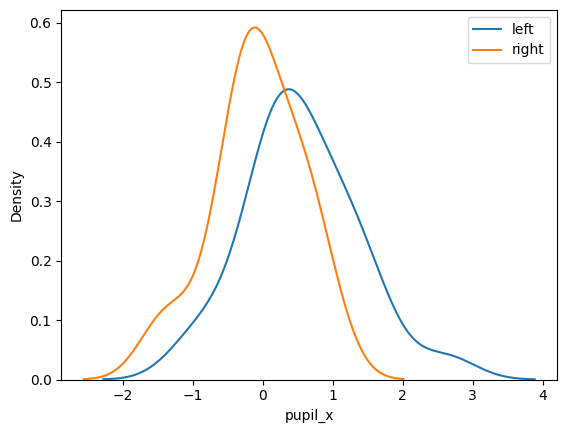

In [31]:
mask_left = np.logical_and(rdf['contrast_left'] >= 50, rdf['contrast_right'] == 0)
df_left = rdf[mask_left]
sns.kdeplot(df_left['pupil_x'], label = 'left')

mask_right = np.logical_and(rdf['contrast_right'] >= 50, rdf['contrast_left'] == 0)
df_right = rdf[mask_right]
sns.kdeplot(df_right['pupil_x'], label = 'right')

plt.legend()


pg.ttest(df_left['pupil_x'], df_right['pupil_x'], paired = True)

As a sanity check, was there a difference in vertical eye position between the left-stimulus trials and the right-stimulus trials?  In trials where there was only one stimulus present (i.e. `contrast_left` or `contrast_right` was zero), and the stimulus had at least a contrast level of 50 (quite visible), was there a difference in the average `pupil_y` position?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.81158,38.482526,two-sided,0.422024,"[-0.2, 0.47]",0.247714,0.39,0.125031


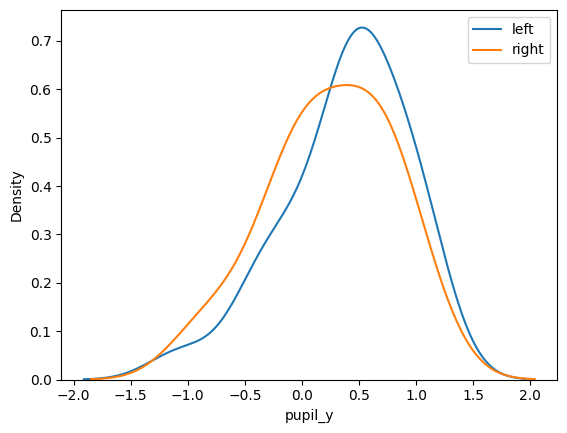

In [32]:
mask_left = np.logical_and(rdf['contrast_left'] >= 50, rdf['contrast_right'] == 0)
df_left = rdf[mask_left]
sns.kdeplot(df_left['pupil_y'], label = 'left')

mask_right = np.logical_and(rdf['contrast_right'] >= 50, rdf['contrast_left'] == 0)
df_right = rdf[mask_right]
sns.kdeplot(df_right['pupil_y'], label = 'right')
plt.legend()

pg.ttest(df_left['pupil_y'], df_right['pupil_y'], paired = False)


In [33]:
print('No, there is no statistical significant difference in pupil position when the stimulus is presented to the left vs. to the right.')

No, there is no statistical significant difference in pupil position when the stimulus is presented to the left vs. to the right.


Did mice look in the direction they turned the wheel?  Was there a difference in average `pupil_x` position between left-turning trials (i.e. `response_type` is -1) and right-turning trials (i.e. `response_type` is 1)?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.472363,78.49085,two-sided,0.015585,"[-0.59, -0.06]",0.50892,3.159,0.610308


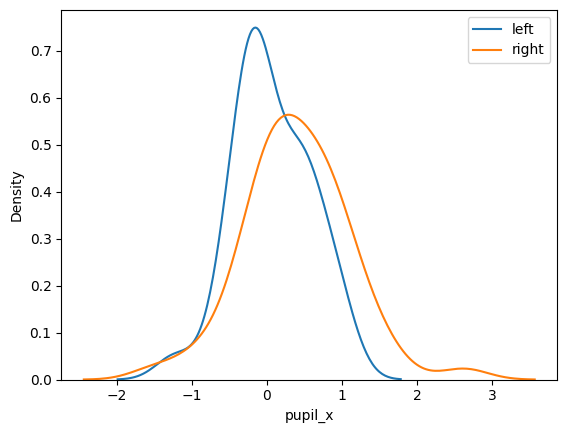

In [34]:
mask_left = rdf['response_type'] == -1
df_left = rdf[mask_left]
sns.kdeplot(df_left['pupil_x'], label = 'left')

mask_right = rdf['response_type'] == 1
df_right = rdf[mask_right]
sns.kdeplot(df_right['pupil_x'], label = 'right')

plt.legend()

pg.ttest(df_left['pupil_x'], df_right['pupil_x'], paired = False)


As a sanity check, did vertical eye position matter?  Was there a difference in average `pupil_y` position between left-turning trials (i.e. `response_type` is -1) and right-turning trials (i.e. `response_type` is 1)?

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.218473,61.22414,two-sided,0.227719,"[-0.1, 0.42]",0.275322,0.443,0.22797


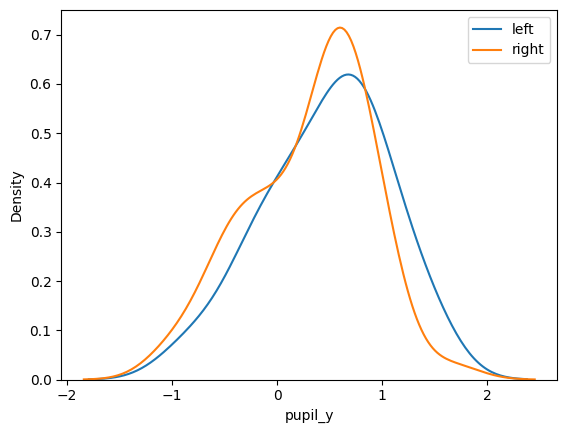

In [35]:
mask_left = rdf['response_type'] == -1
df_left = rdf[mask_left]
sns.kdeplot(df_left['pupil_y'], label = 'left')
mask_right = rdf['response_type'] == 1
df_right = rdf[mask_right]
sns.kdeplot(df_right['pupil_y'], label = 'right')
plt.legend()
pg.ttest(df_left['pupil_y'], df_right['pupil_y'], paired = False)

## Working with Long DataFrames

If data is organized as a long dataframe, it is also possible to have `pingouin` simply do all the comparisons between the groups.  Not only is this very convenient; it also makes it possible for pingouin to do richer analyses.

| Test, | Function | 
| :--- | :--- |
| Melt | `pd.melt()` |
| ANOVA | `pg.anova(data=dfl, dv='value', between=['variable'], detailed=True, )` |
| ANCOVA | `pg.ancova(dfl, dv='value', between=['variable'], covar=['index'], )` |
| Pairwise T-tests | `pg.pairwise_tests(data=dfl, dv='value', between='variable', subject='index', padjust='fdr')`  |  

**Exercises**

Use the `dfl` long dataframe below:

In [82]:
dfl = df.melt(ignore_index=False).reset_index()
dfl.sample(5)

,index,variable,value
14,14,A,0.539840
8,8,A,0.148675
12,12,A,-1.818812
26,6,B,-1.012560
17,17,A,-0.473448


**Example**: Before doing pairwise tests, it's often helpful to run an ANOVA analysis, which can tell you quickly whether a pairwise difference exists within a collection of potential pairs.  Below, run an ANOVA test comparing the dv 'value' between values of 'variable' to see if a significant difference is expected.

In [37]:
pg.anova(dfl, dv='value', between=['variable'], detailed=True, )

,Source,SS,DF,MS,F,p-unc,np2
0,variable,7.259916,3,2.419972,2.851046,0.042862,0.101157
1,Within,64.508906,76,0.848801,NaN,NaN,NaN


Do a t-tests for every possible pairwise comparison of "variable" (e.g. "A" vs "B", "A" vs "C", etc).  (Tip: it works similar to the `pg.anova` function)

In [38]:
pg.pairwise_tests(dfl, dv = 'value', between = ['variable'])

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,variable,A,B,False,True,-0.137189,38.0,two-sided,0.891606,0.311,-0.042521
1,variable,A,C,False,True,-1.978874,38.0,two-sided,0.055111,1.409,-0.613342
2,variable,A,D,False,True,0.068052,38.0,two-sided,0.946101,0.309,0.021092
3,variable,B,C,False,True,-2.139828,38.0,two-sided,0.038851,1.806,-0.663229
4,variable,B,D,False,True,0.302159,38.0,two-sided,0.764179,0.32,0.093653
5,variable,C,D,False,True,2.845162,38.0,two-sided,0.007113,6.461,0.881844


Repeat the tests, but his time, adjust the p-value to compensate for multiple comparisons using the 'fdr' method.  Are the significant differences still significant?  How do the corrected p-values compare to the uncorrected p-values?

In [39]:
pg.pairwise_tests(dfl, dv = 'value', between = ['variable'], padjust = 'fdr_bh')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,variable,A,B,False,True,-0.137189,38.0,two-sided,0.891606,0.946101,fdr_bh,0.311,-0.042521
1,variable,A,C,False,True,-1.978874,38.0,two-sided,0.055111,0.110222,fdr_bh,1.409,-0.613342
2,variable,A,D,False,True,0.068052,38.0,two-sided,0.946101,0.946101,fdr_bh,0.309,0.021092
3,variable,B,C,False,True,-2.139828,38.0,two-sided,0.038851,0.110222,fdr_bh,1.806,-0.663229
4,variable,B,D,False,True,0.302159,38.0,two-sided,0.764179,0.946101,fdr_bh,0.32,0.093653
5,variable,C,D,False,True,2.845162,38.0,two-sided,0.007113,0.042681,fdr_bh,6.461,0.881844


Do a pairwise test again on the long dataframe, comparing the value of 'value' between each value 'variable'.  This time, use a non-parametric comparison (not assuming a normal distribution of each variable), and still adjust for multiple comparisons.  Are your results the same?

In [40]:
pg.pairwise_tests(dfl, dv = 'value', between = ['variable'], padjust = 'fdr_bh', parametric = False)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,variable,A,B,False,False,192.0,two-sided,0.839232,0.967635,fdr_bh,-0.042521
1,variable,A,C,False,False,136.0,two-sided,0.085855,0.171710,fdr_bh,-0.613342
2,variable,A,D,False,False,202.0,two-sided,0.967635,0.967635,fdr_bh,0.021092
3,variable,B,C,False,False,132.0,two-sided,0.067868,0.171710,fdr_bh,-0.663229
4,variable,B,D,False,False,232.0,two-sided,0.394171,0.591256,fdr_bh,0.093653
5,variable,C,D,False,False,273.0,two-sided,0.049864,0.171710,fdr_bh,0.881844


In [41]:
dfl

,index,variable,value
0,0,A,0.276266
1,1,A,-1.854628
2,2,A,0.623901
3,3,A,1.145311
4,4,A,1.037190
...,...,...,...
75,15,D,-0.365784
76,16,D,0.232169
77,17,D,0.315291
78,18,D,0.034847


Use the `rdf` dataframe from the pupil measurement data.  Is there a significant different in average horizontal position, when comparing all the `contrast_diff` levels in the study pairwise?

In [81]:
pg.pairwise_tests(rdf, dv = 'pupil_x', between = ['contrast_diff'], padjust = 'fdr_bh', parametric = False)

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,contrast_diff,-100.0,-75.0,False,False,39.0,two-sided,0.841125,1.000000,fdr_bh,0.003482
1,contrast_diff,-100.0,-50.0,False,False,168.0,two-sided,0.054208,0.252391,fdr_bh,0.707904
2,contrast_diff,-100.0,-25.0,False,False,18.0,two-sided,0.600000,0.964286,fdr_bh,0.399767
3,contrast_diff,-100.0,0.0,False,False,147.0,two-sided,0.070109,0.252391,fdr_bh,0.717534
4,contrast_diff,-100.0,25.0,False,False,42.0,two-sided,0.157516,0.472549,fdr_bh,0.644120
5,contrast_diff,-100.0,50.0,False,False,162.0,two-sided,0.003526,0.042318,fdr_bh,1.179199
6,contrast_diff,-100.0,75.0,False,False,40.0,two-sided,0.232680,0.598319,fdr_bh,0.645830
7,contrast_diff,-100.0,100.0,False,False,112.0,two-sided,0.015099,0.135893,fdr_bh,0.998026
8,contrast_diff,-75.0,-50.0,False,False,81.0,two-sided,0.036257,0.218709,fdr_bh,0.904273
9,contrast_diff,-75.0,-25.0,False,False,8.0,two-sided,0.642857,0.964286,fdr_bh,0.759261


## A Gallery of Plots : 2D Histograms with `sns.jointplot()`

Let's try out a few different plots, for comparing two different continuous variables' distributions.

| Code | Description |
| :--  | :-- |
| `sns.jointplot(df, x='colA', y='colB')` | Makes a joint histogram |

**Exercises**

**Example**: Make a joint plot comparing the `pupil_x` and `pupil_y` variables:

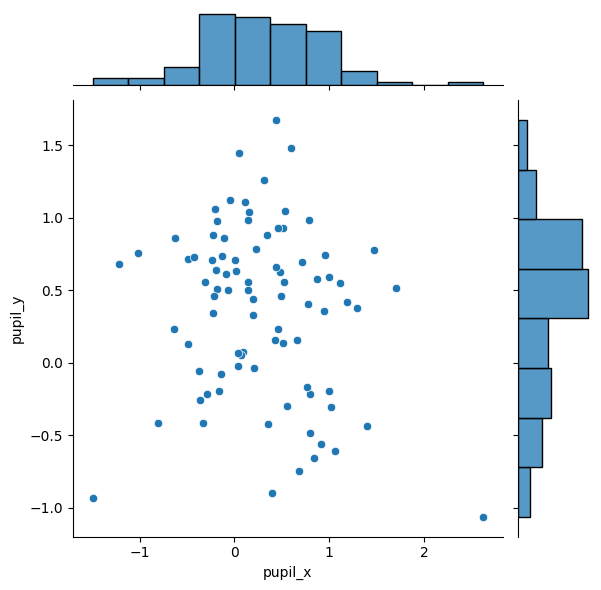

In [43]:
sns.jointplot(rdf, x="pupil_x", y="pupil_y");

Make a joint plot comparing the `pupil_x` and `pupil_y` variables, using `kind='kde'`.

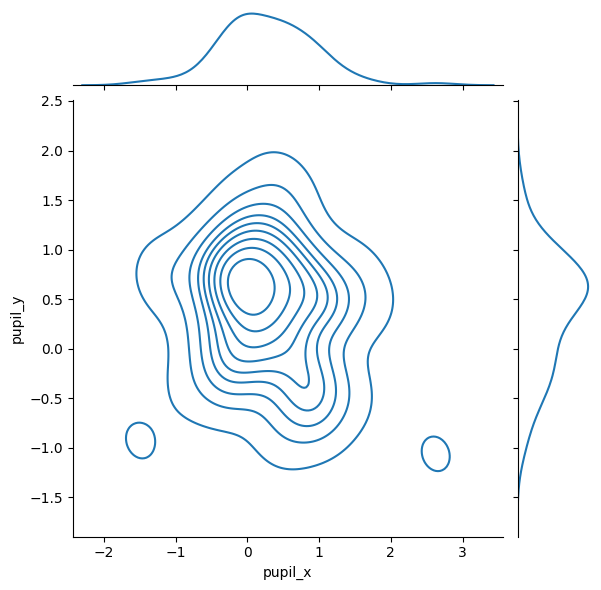

In [44]:
sns.jointplot(rdf, x='pupil_x', y='pupil_y', kind = 'kde')

Make a joint plot comparing the `pupil_x` and `pupil_y` variables, using `kind='kde'` and setting `hue` to `'response_type'`.

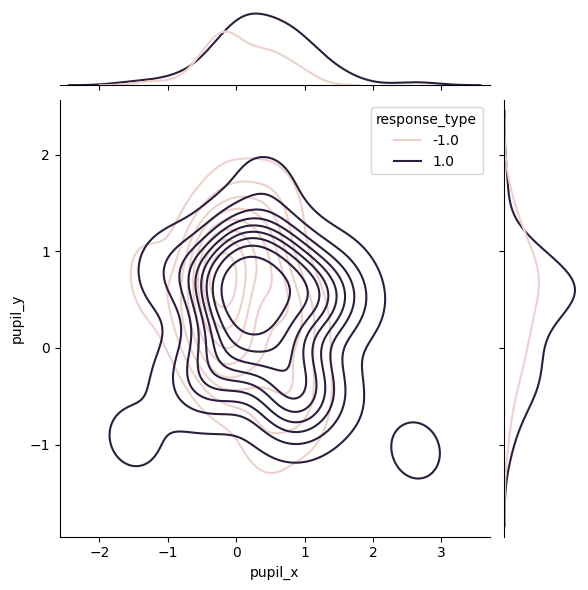

In [45]:
sns.jointplot(rdf, x='pupil_x', y='pupil_y', kind = 'kde', hue='response_type')

Make a joint plot comparing the `pupil_x` and `pupil_y` variables, using `kind='hex'`.

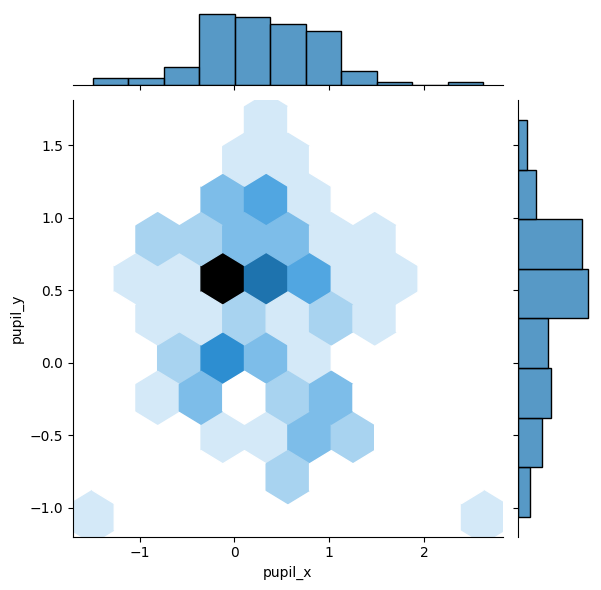

In [46]:
sns.jointplot(rdf, x='pupil_x', y='pupil_y', kind='hex')

## Further Reading

Nice article on Pingouin here: https://towardsdatascience.com/the-new-kid-on-the-statistics-in-python-block-pingouin-6b353a1db57c

Nice summary of the different effect size metrics and when to pick which: https://www.socscistatistics.com/effectsize/default3.aspx

## Extra: Correlations and Simpson's Paradox

| Function | Description |
| :-- | :-- |
| `pg.corr(A, B)` | The correlation between variables A and B |
| `pg.pairwise_corr(flowers)` | Pairwise correlations |
| `df.plot.scatter(x='A', y='B')` | Make a scatter plot |
| `sns.lmplot(data=df, x='Col1', y='Col2', hue='Col3')` | Make a scatter plot with a regression line |

Download the iris dataset for this section:

In [47]:
%pip install bokeh bokeh_sampledata

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   -------- ------------------------------- 1.6/7.0 MB 8.4 MB/s eta 0:00:01
   ---------------- ----------------------- 2.9/7.0 MB 7.0 MB/s eta 0:00:01
   ------------------------- -------------- 4.5/7.0 MB 7.5 MB/s eta 0:00:01
   ---------------------------------- ----- 6.0/7.0 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 7.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/17.6 MB ? eta -:--:--
   -- ------------------------------------- 1.3/17.6 MB 6.8 MB/s eta 0:00:03
   ------ --------------------------------- 2.9/17.6 MB 7.7 MB/s eta 0:00:02
   ---------- ----------------------------- 4.5/17.6 MB 7.4 MB/s eta 0:00:02
   ------------- -------------------------- 5.8/17.6 MB 7.0 MB/s eta 0:00:02
   ---------------- ------------------

In [48]:
from bokeh import sampledata
# sampledata.download()

In [49]:
from bokeh.sampledata import iris
flowers = iris.flowers
flowers.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


**Exercises**:

Is there a correlation between flowers' sepal widths and their petal lengths?

In [50]:
pg.corr(flowers['sepal_width'], flowers['petal_length'])

,n,r,CI95%,p-val,BF10,power
pearson,150,-0.42844,"[-0.55, -0.29]",4.513314e-08,2.762e+05,0.999847


In [52]:
pg.corr(flowers['sepal_width'], flowers['petal_length'], method='spearman')

,n,r,CI95%,p-val,power
spearman,150,-0.309635,"[-0.45, -0.16]",0.000115,0.973396


Use seaborn's `lmplot()` function to plot a regression line showing the sepal widths and petal lengths.  Does the direction of this line match the results?  Looking closely at the data's distribution, what is missing from this story?

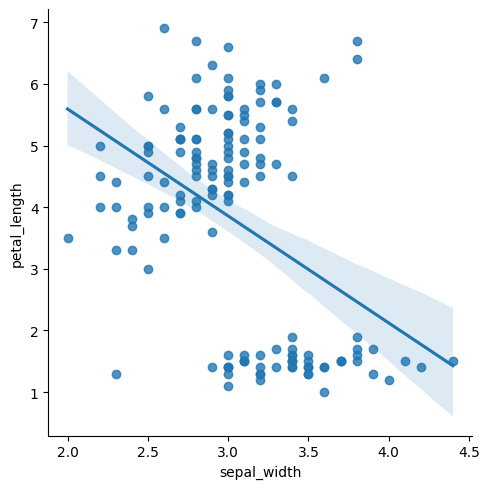

In [58]:
sns.lmplot(data=flowers, x='sepal_width', y = 'petal_length')

This time factor in the `species` variable into the `lmplot()` visualization.  What kind of relationship do you see between `sepal_width` and `petal_length` now?

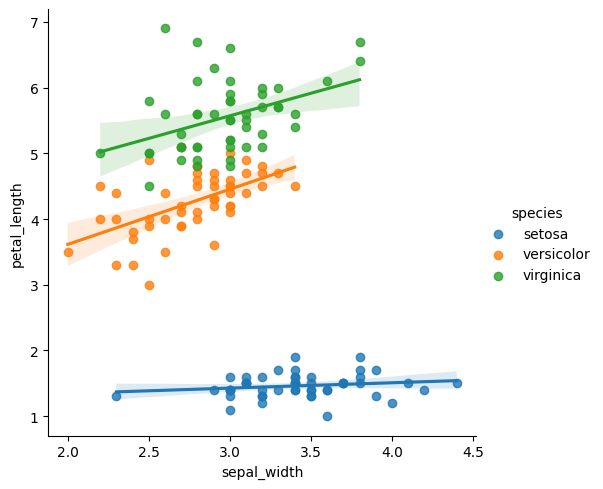

In [59]:
sns.lmplot(data=flowers, x='sepal_width', y='petal_length', hue='species')

What's happening here is that a third variable, `"species"`, is influencing both the petal and the sepal shape; this effect is called "Simpson's Paradox".   Unfortunately, at this time (as far as I know) pengouin doesn't have a way to split a correlation into multiple groups; one way to do this, though, is to use a `df.groupby()` analysis:

In [74]:
fun = lambda data: pg.corr(data['sepal_width'], data['petal_length'])
flowers.groupby('species').apply(fun, include_groups=False)

,,n,r,CI95%,p-val,BF10,power
species,,,,,,,
setosa,pearson,50,0.177700,"[-0.11, 0.43]",0.216979,0.37,0.236771
versicolor,pearson,50,0.560522,"[0.33, 0.73]",0.000023,1061.04,0.992245
virginica,pearson,50,0.401045,"[0.14, 0.61]",0.003898,10.094,0.836041


To summarize, accounting for the right variables is a big part of science; we should always be aware that the patterns we see in our data can be turned completely upside down when new aspects of a problem are understood and factored in!  